# PROYECTO FINAL - PREDICCIÓN PRECIO CASAS

**A modo de guia, los pasos serán los siguientes:**

**1) Definir el problema:** El primer y uno de los más importantes pasos en cualquier creación de un modelo de Machine Learning es definir el problema, para que va a ser utilizado el modelo y definir cual es el objetivo. 

**2) Recopilar y explorar los datos:** Generar un reporte de calidad de datos (DQR) con el cual vamos a familiarizarnos más con la data y entender que faltantes hay y como mejorarla.

**3) Limpieza de Datos:** Manejar cualquier dato faltante o inconsistente. Esto implica completar valores faltantes, corregir errores, eliminar duplicados, identificar y manejar outliers etc.

**4) Feature Engineering:** Crear nuevas variables o modificar las existentes para mejorar el rendimiento del modelo. Esto puede implicar normalizar valores numéricos, codificar variables categóricas, generar términos de interacción etc.

**5) Feature Selection:** Despues de crear nuevas, modificar o mejorar las variables existentes pasamos a hacer feature selection en caso de contar con muchas dado que esto es un problema para los modelos de ML no lineales. Reducir dimencionalidad con filters o wrappers. 

**6) Modelo Base:** Despues de tener todas las variables como queremos y habiendo identificado las mejores, crear un modelo base para tener como comparación. Dado que modelos más complejos, no lineales, deberían performar mejor.

**7) Modelos no lineales:** Implementar modelos no lineales, hacer Fine tune de Hyperparameters y comparar que modelos performar mejor teniendo en cuenta el mix entre complejidad, performance y overfitting.

**8) Implementación y resultados:** Implementar modelo, monitorear y reconstruir en caso de ser necesario.

## 1) Definir el problema

### Contexto
El mercado inmobiliario presenta gran variabilidad en los precios de las viviendas debido a factores como la ubicación, la superficie, la cantidad de ambientes, el estado de la propiedad y otros atributos. Poder estimar el precio de una casa de manera precisa resulta clave para compradores, vendedores y agencias inmobiliarias.


### Enunciado
Se cuenta con un conjunto de datos proveniente de Kaggle, que contiene información detallada sobre distintas propiedades y sus características (como superficie, número de habitaciones, antigüedad, entre otras), junto con su precio de venta. El objetivo es construir un modelo que, a partir de estas variables, permita predecir el precio de una vivienda.

### Objetivo
Desarrollar un modelo capaz de estimar el precio de una vivienda en función de sus atributos, aplicando técnicas de limpieza, análisis exploratorio y modelado predictivo, y evaluando diferentes algoritmos para identificar el que logre el mejor desempeño.

## 2) Recopilar y explorar datos

### Data y comentarios iniciales

In [1]:
# Importamos librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Importamos el dataset brindado por el profesor
data = pd.read_csv('House_price_regression_dataset_2.csv')
data.shape

(1046, 8)

In [3]:
# Vemos las primeras 10 filas del dataset
data.head(10)

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360.0,2,1,1981,0.599637,0,5,2.623829e+05
1,4272.0,3,3,2016,4.753014,1,6,9.852609e+05
2,3592.0,1,2,2016,3.634823,zero,9,7.779774e+05
3,966.0,1,2,1977,2.730667,1,8,2.296989e+05
4,4926.0,2,1,1993,4.699073,0,8,1.041741e+06
5,3944.0,5,3,1990,2.475930,2,8,8.797970e+05
6,3671.0,1,2,2012,4.911960,0,1,8.144279e+05
7,3419.0,1,1,1972,2.805281,1,1,7.034131e+05
8,630.0,3,3,1997,1.014286,one,8,1.738750e+05
9,2185.0,4,2,1981,3.941604,2,5,5.041765e+05


In [4]:
# Vemos los tipos de datos de las columnas y identificamos si hay o no valores nulos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1044 non-null   float64
 1   Num_Bedrooms          1046 non-null   object 
 2   Num_Bathrooms         1046 non-null   int64  
 3   Year_Built            1046 non-null   int64  
 4   Lot_Size              1046 non-null   float64
 5   Garage_Size           1046 non-null   object 
 6   Neighborhood_Quality  1046 non-null   int64  
 7   House_Price           1046 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 65.5+ KB


**Comentarios hasta acá**
1. El dataset cuenta con 1.046 observaciones y 8 variables.
2. La variable *Square_Footage* presenta 2 valores faltantes, por lo que será necesario decidir como tratarlos durante la limpieza de datos.
3. Las variables *Num_Bedrooms* y *Garage_Size* estan categorizadas como object, aunque deberían ser numéricas. Identificar porque y limpiar/modificar en caso de ser necesario.
4. No hay variables categorícas en formato texto, pero *Neighborhood_Quality* es una variable ordinal que califica la calidad del barrio del 1 al 10 (siendo 10 la mejor). 

### Explorar los campos inicialmente marcados como de tipo numerico (int, float)

In [5]:
# Veamos las estadisticas de las columnas inicialemnte cateogrizadas como numéricas para empeazar a entender el dataset 
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_cols].describe()

,Square_Footage,Num_Bathrooms,Year_Built,Lot_Size,Neighborhood_Quality,House_Price
count,1044.000000,1046.000000,1046.000000,1046.000000,1046.000000,1.046000e+03
mean,2832.542146,1.981836,1986.476099,2.813626,5.661568,6.403109e+05
std,1289.006441,0.837320,20.605961,1.372383,2.897647,5.011310e+05
min,0.000000,1.000000,1950.000000,0.506058,1.000000,1.116269e+05
25%,1755.500000,1.000000,1969.000000,1.723039,3.000000,4.053437e+05
50%,2888.500000,2.000000,1986.000000,2.850605,6.000000,6.358251e+05
75%,3868.250000,3.000000,2004.000000,3.955455,8.000000,8.319290e+05
max,9000.000000,6.000000,2022.000000,15.000000,10.000000,1.100000e+07


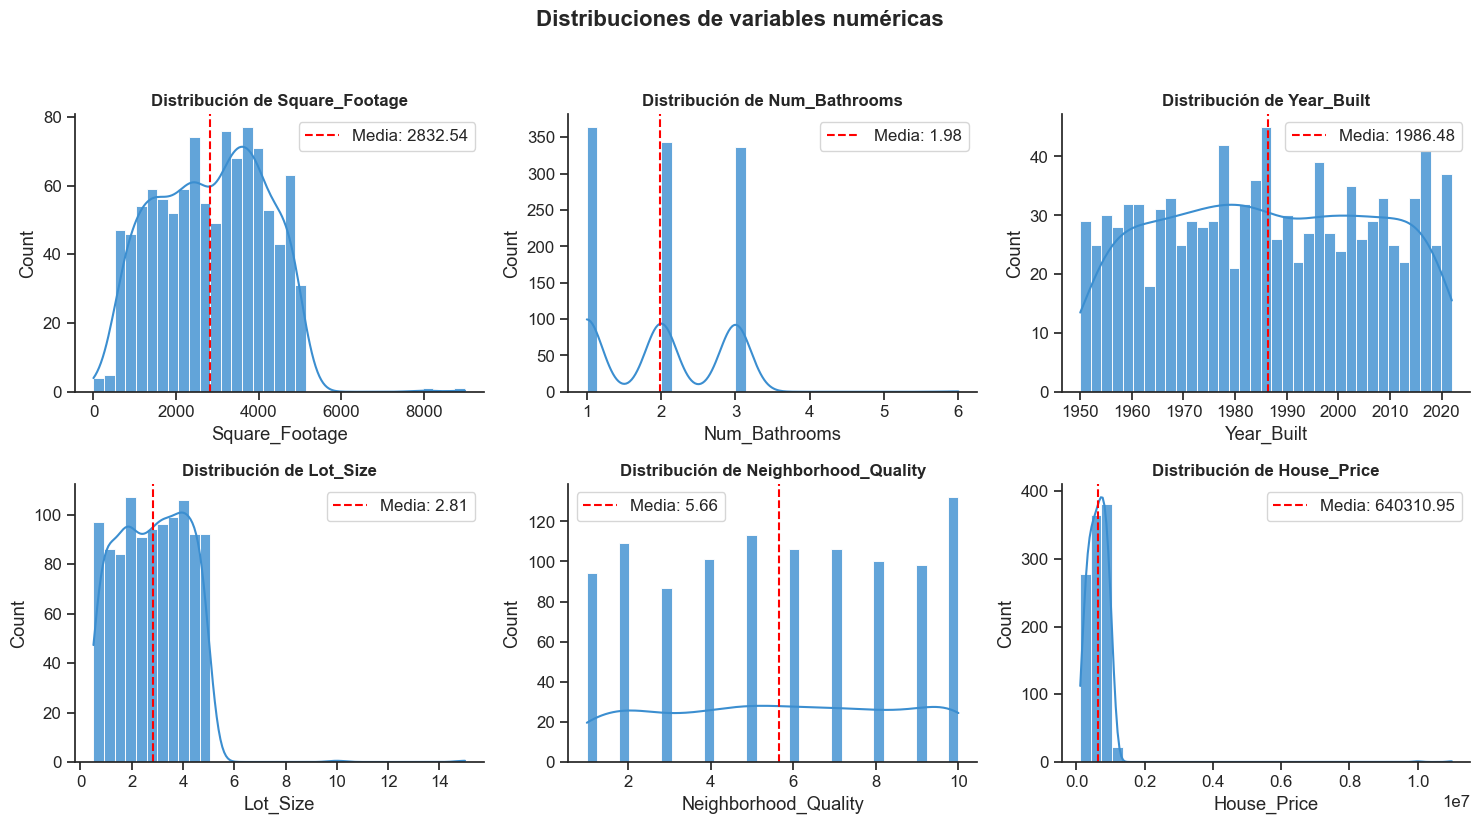

In [6]:
# Realizamos histograma inicial de las variables numericas para ver la distribución de los datos e identificar si hay valores atípicos
sns.set_theme(style="ticks", font_scale=1.1)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], bins=35, kde=True, ax=axes[i], color="#3b8ed0", edgecolor="white", alpha=0.8)
    mean = np.nanmean(data[col])
    axes[i].axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean:.2f}')
    axes[i].set_title(f"Distribución de {col}", fontsize=12, fontweight="bold")
    axes[i].legend()
    sns.despine(ax=axes[i])

plt.suptitle("Distribuciones de variables numéricas", fontsize=16, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

**Comentarios hasta acá**
1. Las variables numéricas presentan rangos amplios, lo que sugiere la necesidad de considerar normalizacion o estandarizacion de las variables antes de realizar el modelo.
2. En *Square_Footage* y *Lot_Size* se observa una fuerte asimetría positiva, la mayoria de las casas tienen superficies medias, pero existen algunas muy grandes que actuan como outliers.
3. *Neighborhood_Quality* toma valores enteros de 1 a 10, confirmando que se trata de una variable ordinal que mide niveles de calidad.
4. *House_Price* presenta un sesgo a la derecha muy marcado: la mayoría de las viviendas se ubica en rangos de precios bajos-medios, mientras unas pocas alcanzan valores extremadamente altos.

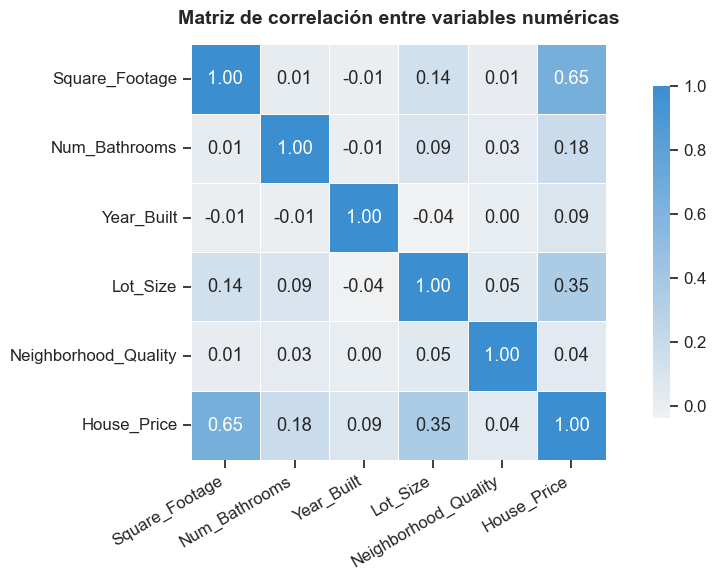

In [7]:
# Vemos correlación entre variables numéricas
plt.figure(figsize=(10, 6))

sns.heatmap(
    data[numeric_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap=sns.light_palette("#3b8ed0", as_cmap=True),
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    square=True
)

plt.title("Matriz de correlación entre variables numéricas", fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Comentario:** Se observa una correlación moderada entre el precio y la superficie, mientras que el resto de las variables muestran relaciones relativamente débiles. No se detectan correlaciones fuertes entre las variables explicativas, por lo que no habría problemas de multicolinealidad.

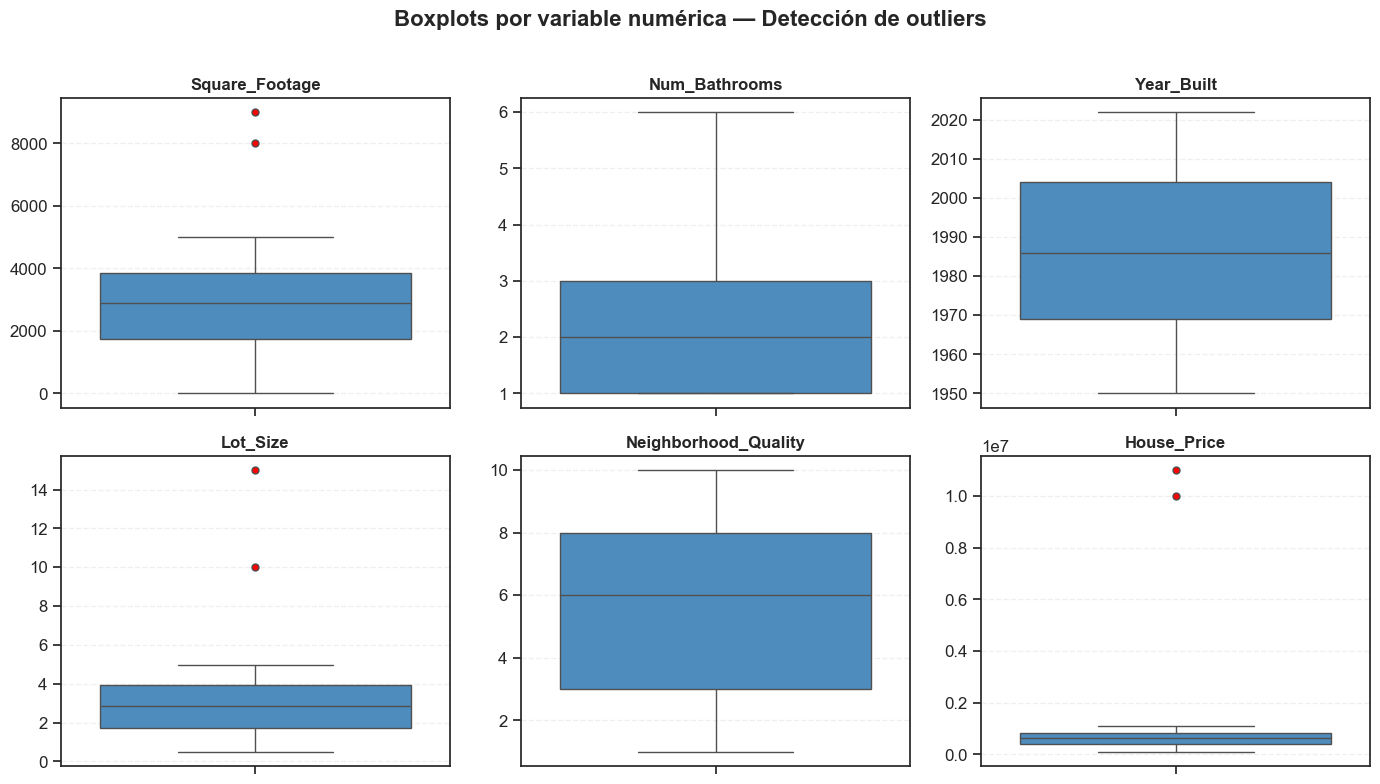

In [8]:
# Boxplots para detección de valores atípicos en variables numéricas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        y=data[col],
        color="#3b8ed0",
        flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'),
        ax=axes[i]
    )
    axes[i].set_title(f"{col}", fontsize=12, weight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

# Eliminar ejes vacíos si hay menos variables que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplots por variable numérica — Detección de outliers", fontsize=16, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Explorar los campos inicialmente marcados como de tipo object

In [9]:
for col in data.select_dtypes(include=['object']).columns:
    print(f"\n--- Distribución de '{col}' ---")
    print(data[col].value_counts(dropna=False))
    print(f"Número de categorías únicas: {data[col].nunique()}")
    print('-------------------------------------------')


--- Distribución de 'Num_Bedrooms' ---
Num_Bedrooms
2        225
5        211
1        210
4        204
3        188
two        2
three      1
five       1
four       1
one        1
10         1
15         1
Name: count, dtype: int64
Número de categorías únicas: 12
-------------------------------------------

--- Distribución de 'Garage_Size' ---
Garage_Size
2       355
1       352
0       329
one       3
two       3
zero      2
10        2
Name: count, dtype: int64
Número de categorías únicas: 7
-------------------------------------------


**Comentario:** Las variables categóricas identificadas *Num_Bedrooms* y *Garage_Size* en realidad representan datos numéricos. Por lo tanto, será necesario convertirlas a formato numérico para garantizar la consistencia del dataset y permitir un correcto análisis y modelado posterior.

### Modificar dtype

In [10]:
# Diccionario para reemplazar valores textuales por su equivalente numérico
text_to_num = {
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "fifteen": 15
}

# Aplicamos reemplazo en las columnas problemáticas de las variables inicialmente marcadas como de tipo object
data["Num_Bedrooms"] = data["Num_Bedrooms"].replace(text_to_num).astype(float)
data["Garage_Size"] = data["Garage_Size"].replace(text_to_num).astype(float)

# Verificamos el cambio
print(data[["Num_Bedrooms", "Garage_Size"]].dtypes)

Num_Bedrooms    float64
Garage_Size     float64
dtype: object


In [11]:
# Chequeamos los los data types de las columnas
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046 entries, 0 to 1045
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1044 non-null   float64
 1   Num_Bedrooms          1046 non-null   float64
 2   Num_Bathrooms         1046 non-null   int64  
 3   Year_Built            1046 non-null   int64  
 4   Lot_Size              1046 non-null   float64
 5   Garage_Size           1046 non-null   float64
 6   Neighborhood_Quality  1046 non-null   int64  
 7   House_Price           1046 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 65.5 KB


### Data Quality Report

In [12]:
dqr = pd.DataFrame({
    'Tipo de Dato': data.dtypes,
    'Valores No Nulos': data.notnull().sum(),
    'Valores Nulos': data.isnull().sum(),
    'Porcentaje Nulos (%)': round((data.isnull().sum() / len(data)) * 100, 2),
    'Valores Únicos': data.nunique(),
    'Valor Mínimo': data.min(numeric_only=True),
    'Valor Máximo': data.max(numeric_only=True),
    'Media': data.mean(numeric_only=True),
    'Desvío Estándar': data.std(numeric_only=True)
})

dqr

,Tipo de Dato,Valores No Nulos,Valores Nulos,Porcentaje Nulos (%),Valores Únicos,Valor Mínimo,Valor Máximo,Media,Desvío Estándar
Square_Footage,float64,1044,2,0.19,892,0.000000,9000.0,2832.542146,1289.006441
Num_Bedrooms,float64,1046,0,0.00,7,1.000000,15.0,2.999044,1.489035
Num_Bathrooms,int64,1046,0,0.00,4,1.000000,6.0,1.981836,0.837320
Year_Built,int64,1046,0,0.00,73,1950.000000,2022.0,1986.476099,20.605961
Lot_Size,float64,1046,0,0.00,1002,0.506058,15.0,2.813626,1.372383
Garage_Size,float64,1046,0,0.00,4,0.000000,10.0,1.043021,0.901389
Neighborhood_Quality,int64,1046,0,0.00,10,1.000000,10.0,5.661568,2.897647
House_Price,float64,1046,0,0.00,1002,111626.853424,11000000.0,640310.945060,501130.967710


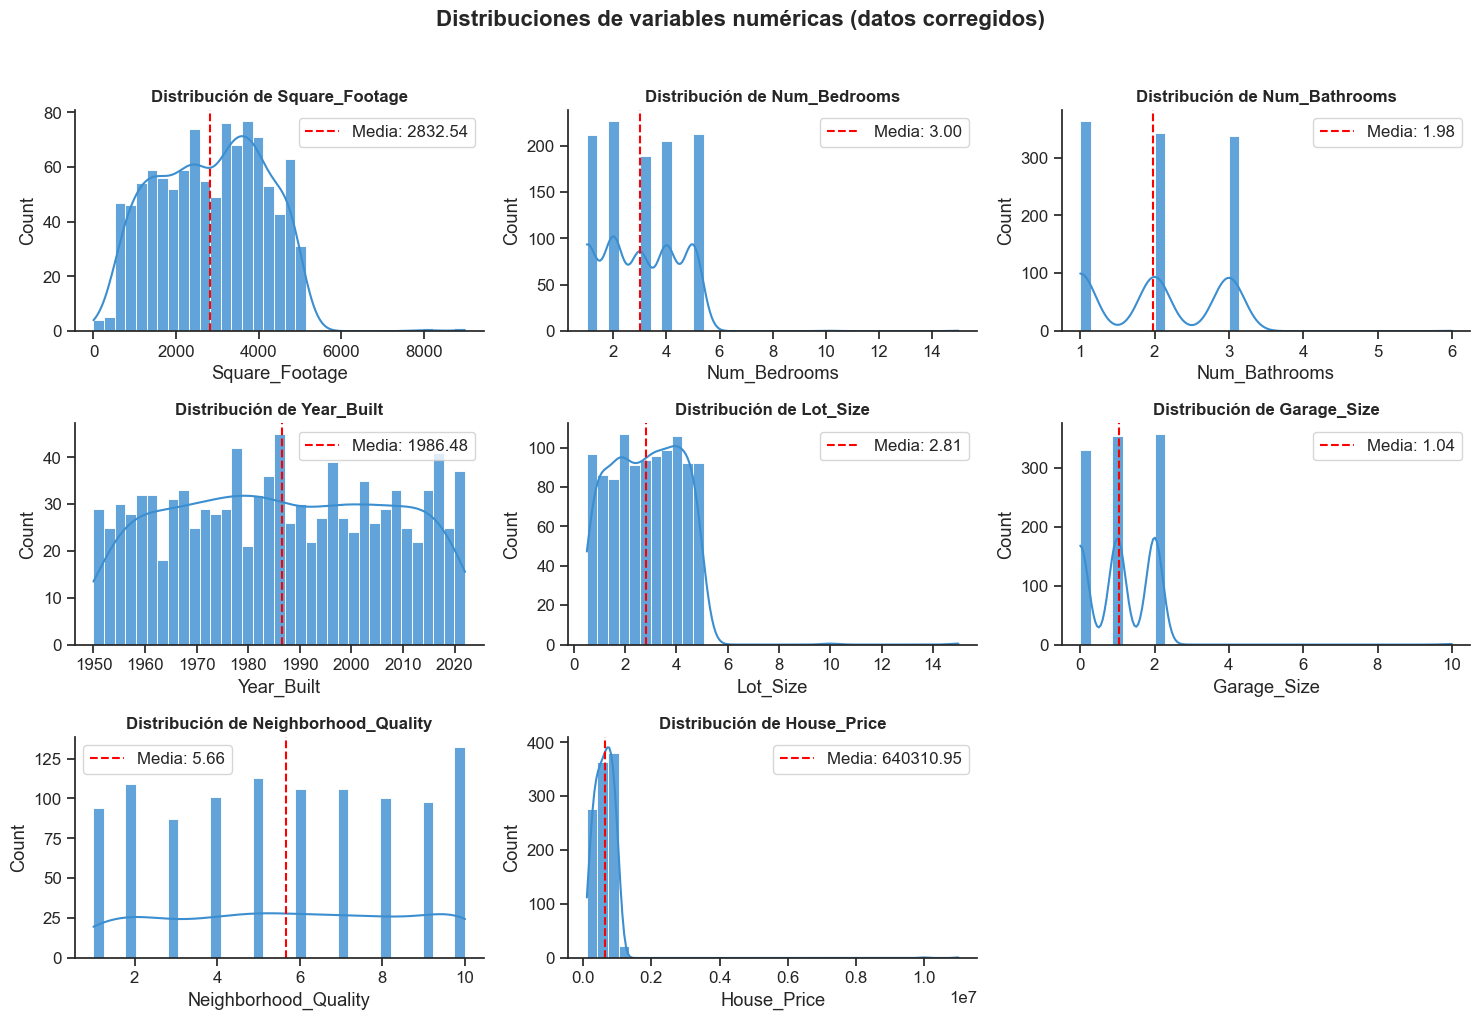

In [13]:
# Graficamos nuevamente para entender las distribuciones
sns.set_theme(style="ticks", font_scale=1.1)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(
        data[col], bins=35, kde=True, ax=axes[i],
        color="#3b8ed0", edgecolor="white", alpha=0.8
    )
    mean = np.nanmean(data[col])
    axes[i].axvline(mean, color='red', linestyle='--', linewidth=1.5, label=f'Media: {mean:.2f}')
    axes[i].set_title(f"Distribución de {col}", fontsize=12, fontweight="bold")
    axes[i].legend()
    sns.despine(ax=axes[i])
    
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribuciones de variables numéricas (datos corregidos)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

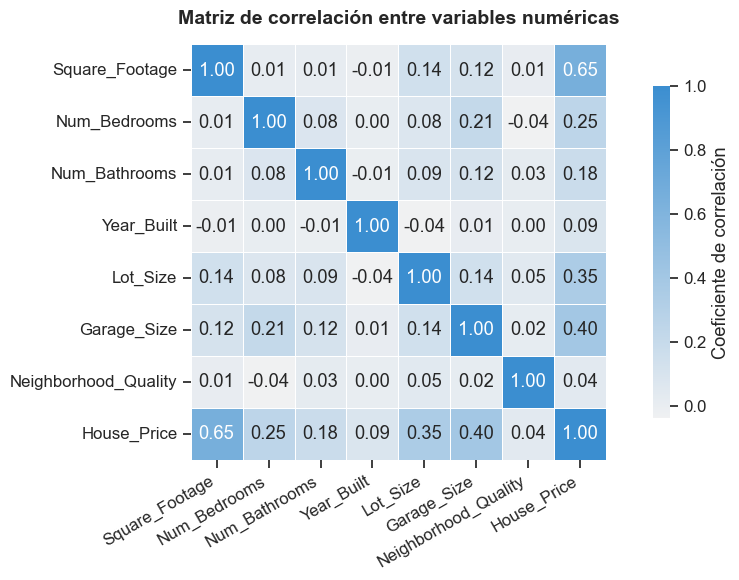

In [14]:
# Correlación entre variables numéricas
plt.figure(figsize=(10, 6))

corr_matrix = data[numeric_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=sns.light_palette("#3b8ed0", as_cmap=True),
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Coeficiente de correlación'},
    square=True
)

plt.title("Matriz de correlación entre variables numéricas", fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

**Comentarios hasta acá:**
1. El dataset se encuentra en buen estado general: solo la variable *Square_Footage* presenta 2 valores nulos (0.19%), mientras que las demás no tienen datos faltantes.  
2. Los tipos de datos son correctos (float64 e int64), aunque *Neighborhood_Quality* debe interpretarse como una variable ordinal (1 a 10) y no estrictamente numérica continua.  
3. El valor mínimo de *Square_Footage* igual a 0 sugiere que podría tratarse de un terreno sin construcción, aunque también es posible que sea un error en los datos y conviene verificarlo
4. *House_Price* muestra un rango muy amplio (de 111,626 a 11,000,000), lo que sugiere posibles outliers.    


## 3) Limpieza de datos

### Duplicados, faltantes y errores estructurales

In [15]:
datos_limpios = data.copy()
datos_limpios.shape

(1046, 8)

In [16]:
#Eliminar duplicados exactos
datos_limpios = datos_limpios.drop_duplicates()
datos_limpios.shape

(1003, 8)

In [17]:
# Ver observaciones con Square_Footage = 0
datos_limpios[datos_limpios['Square_Footage'] == 0]

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
860,0.0,5.0,1,2010,1.246555,1.0,6,360372.978039
867,0.0,2.0,3,1997,4.383541,0.0,4,953339.730645
955,0.0,4.0,1,2006,1.770181,0.0,7,317780.594286
986,0.0,3.0,2,1958,4.658485,2.0,4,453579.105534


In [18]:
datos_limpios[datos_limpios['Square_Footage'].isna()]

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
738,NaN,2.0,3,2017,0.727516,2.0,9,307116.679137
815,NaN,2.0,3,1994,2.802374,0.0,8,402002.484427


**Comentario:**
Se identificaron 4 observaciones con Square_Footage = 0, pero todas presentan valores positivos en número de dormitorios, baños y precio de venta. Además se identificaron 2 valores faltantes.
Esto indica que no se trata de terrenos sin construcción, sino de errores en la carga de datos. 

En lugar de eliminarlas, se imputará su valor utilizando el método del vecino más cercano (KNN), que estima la variable faltante en función de propiedades con características similares.

In [19]:
# Crear máscara de las filas que tienen Square_Footage == 0 o NaN 
mask_cero_o_nan = (datos_limpios['Square_Footage'] == 0) | (datos_limpios['Square_Footage'].isna())
indices_problematicos = datos_limpios[mask_cero_o_nan].index.tolist()
print("Filas con Square_Footage == 0 o NaN (a imputar):", indices_problematicos)

# Marcar 0s como NaN para que el imputador los trate como faltantes
datos_limpios.loc[datos_limpios['Square_Footage'] == 0, 'Square_Footage'] = np.nan

# Seleccionar columnas numéricas que usará KNN 
num_cols = datos_limpios.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas usadas para imputación:", num_cols)

# Ejecutar KNNImputer sobre la matriz numérica completa 
imputer = KNNImputer(n_neighbors=3)
imputed_array = imputer.fit_transform(datos_limpios[num_cols])

# Pasar a DataFrame preservando el índice original para evitar desalineos
temp_df = pd.DataFrame(imputed_array, columns=num_cols, index=datos_limpios.index)

# Actualizar únicamente las filas problemáticas de Square_Footage
datos_limpios.loc[indices_problematicos, 'Square_Footage'] = temp_df.loc[indices_problematicos, 'Square_Footage']

# Verificación
print("Valores faltantes en Square_Footage después de imputar:",
      datos_limpios['Square_Footage'].isna().sum())
print("Cantidad de filas imputadas (debería coincidir):", len(indices_problematicos))

Filas con Square_Footage == 0 o NaN (a imputar): [738, 815, 860, 867, 955, 986]
Columnas numéricas usadas para imputación: ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Lot_Size', 'Garage_Size', 'Neighborhood_Quality', 'House_Price']
Valores faltantes en Square_Footage después de imputar: 0
Cantidad de filas imputadas (debería coincidir): 6


In [20]:
# Verificamos los cambios
indices_cero = [738, 815, 860, 867, 955, 986]
print(datos_limpios.loc[indices_cero, ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size']])

     Square_Footage  Num_Bedrooms  Num_Bathrooms  Lot_Size
738     1176.666667           2.0              3  0.727516
815     1681.333333           2.0              3  2.802374
860     1570.000000           5.0              1  1.246555
867     4619.000000           2.0              3  4.383541
955     1397.666667           4.0              1  1.770181
986     2001.333333           3.0              2  4.658485


In [21]:
# Modificamos tipo de Num_Bedrooms
datos_limpios['Num_Bedrooms'] = datos_limpios['Num_Bedrooms'].astype(int)

In [22]:
datos_limpios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1003 entries, 0 to 1045
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1003 non-null   float64
 1   Num_Bedrooms          1003 non-null   int64  
 2   Num_Bathrooms         1003 non-null   int64  
 3   Year_Built            1003 non-null   int64  
 4   Lot_Size              1003 non-null   float64
 5   Garage_Size           1003 non-null   float64
 6   Neighborhood_Quality  1003 non-null   int64  
 7   House_Price           1003 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 102.8 KB


In [23]:
# Verificamos si quedo algun nulo
print(datos_limpios.isnull().sum())

Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64


### Outliers

Cantidad de outliers detectados: 2


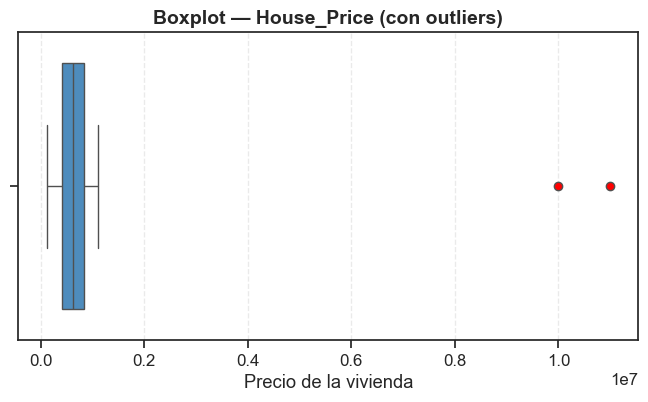

In [24]:
# Detectar outliers con el método IQR
Q1 = datos_limpios['House_Price'].quantile(0.25)
Q3 = datos_limpios['House_Price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = datos_limpios[
    (datos_limpios['House_Price'] < lower) | 
    (datos_limpios['House_Price'] > upper)
]
print(f"Cantidad de outliers detectados: {len(outliers)}")

# Visualizar los outliers con boxplot horizontal
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=datos_limpios['House_Price'],   # <-- horizontal
    color="#3b8ed0",
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
)
plt.title("Boxplot — House_Price (con outliers)", fontsize=14, weight="bold")
plt.xlabel("Precio de la vivienda")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()


Cantidad de outliers detectados: 2


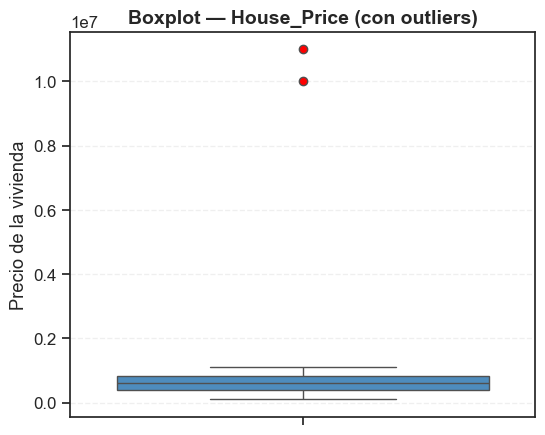

In [323]:
# Detectar outliers con el método IQR
Q1 = datos_limpios['House_Price'].quantile(0.25)
Q3 = datos_limpios['House_Price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = datos_limpios[(datos_limpios['House_Price'] < lower) | (datos_limpios['House_Price'] > upper)]
print(f"Cantidad de outliers detectados: {len(outliers)}")

# Visualizar los outliers con boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(
    y=datos_limpios['House_Price'],
    color="#3b8ed0",
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
)
plt.title("Boxplot — House_Price (con outliers)", fontsize=14, weight="bold")
plt.ylabel("Precio de la vivienda")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


In [324]:
# Eliminamos los outliers
datos_sin_outliers = datos_limpios[(datos_limpios['House_Price'] >= lower) & (datos_limpios['House_Price'] <= upper)]
print(f"Dataset original: {datos_limpios.shape[0]} filas")
print(f"Dataset sin outliers: {datos_sin_outliers.shape[0]} filas")

Dataset original: 1003 filas
Dataset sin outliers: 1001 filas


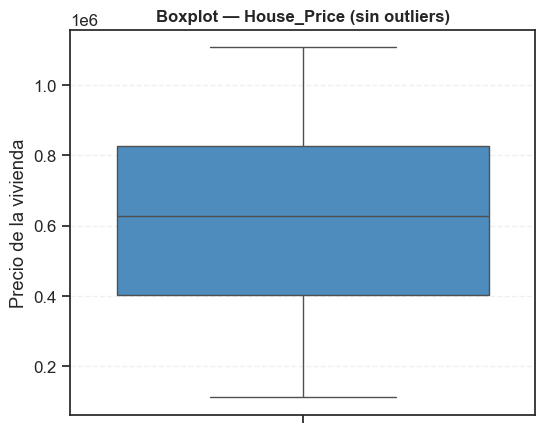

In [325]:
# Graficamos nuevamente para verificar
fig, axes = plt.subplots(1, 1, figsize=(6, 5))

sns.boxplot(
    y=datos_sin_outliers['House_Price'],
    color="#3b8ed0",
    flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'),
    ax=axes
)
axes.set_title("Boxplot — House_Price (sin outliers)", fontsize=12, weight="bold")
axes.set_xlabel("")
axes.set_ylabel("Precio de la vivienda")
axes.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [326]:
datos_sin_outliers['House_Price'].max()

1108236.8362913695

**Comentario:** Durante el análisis inicial se identificaron dos observaciones con precios de vivienda extremadamente altos (USD 10.000.000 y USD 11.000.000), valores muy superiores al resto del conjunto, cuyo precio máximo siguiente rondaba los USD 1.000.000.
Si bien ambas corresponden a transacciones legítimas, su magnitud y carácter excepcional podrían distorsionar los resultados del modelo, reduciendo su capacidad para predecir con precisión los precios de viviendas representativas del mercado.
Por este motivo, las dos observaciones fueron consideradas outliers extremos y se excluyeron del conjunto de datos antes del modelado. Tras su eliminación, el nuevo precio máximo registrado en el dataset es de aproximadamente USD 1.108.236, lo que refleja una distribución más coherente y representativa del mercado analizado.

## 4) Feature Engineering

### Transformación de variables existentes

In [327]:
# Estandarizamos algunas de las variables
cols_to_scale = ['Square_Footage', 'Lot_Size', 'Neighborhood_Quality']
scaler = StandardScaler()
datos_sin_outliers.loc[:, cols_to_scale] = scaler.fit_transform(datos_sin_outliers[cols_to_scale])

/var/folders/38/mbqpzvy531x6cn4lt_zxqnym0000gn/T/ipykernel_56108/352339299.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.21264001  0.13402554  1.17402219 ...  0.48069109 -1.25263665
 -0.55930556]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  datos_sin_outliers.loc[:, cols_to_scale] = scaler.fit_transform(datos_sin_outliers[cols_to_scale])


In [328]:
# Modificamos la variable Year_Built a otra que repesenta la antiguedad de la propiedad
data_fin = datos_sin_outliers.copy()

# Crear la variable House_Age
data_fin['House_Age'] = 2025 - data_fin['Year_Built']

# Asegurar que no haya valores negativos
data_fin['House_Age'] = data_fin['House_Age'].clip(lower=0)

# Eliminamos Year_Built para evitar multicolinealidad
data_fin = data_fin.drop(columns=['Year_Built'])

# Verificamos resultado
data_fin.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,House_Age
0,-1.159530,2,1,-1.679805,0.0,-0.212640,2.623829e+05,44
1,1.161226,3,3,1.520108,1.0,0.134026,9.852609e+05,9
2,0.619291,1,2,0.658613,0.0,1.174022,7.779774e+05,9
3,-1.473534,1,2,-0.037982,1.0,0.827357,2.296989e+05,48
4,1.682440,2,1,1.478549,0.0,0.827357,1.041741e+06,32


In [329]:
# Crear variable logarítmica del precio
data_fin['House_Price_log'] = np.log(data_fin['House_Price'])

In [330]:
# Eliminar la versión original del precio para evitar duplicidad
data_fin = data_fin.drop(columns=['House_Price'])
data_fin.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,House_Age,House_Price_log
0,-1.159530,2,1,-1.679805,0.0,-0.212640,44,12.477560
1,1.161226,3,3,1.520108,1.0,0.134026,9,13.800662
2,0.619291,1,2,0.658613,0.0,1.174022,9,13.564453
3,-1.473534,1,2,-0.037982,1.0,0.827357,48,12.344525
4,1.682440,2,1,1.478549,0.0,0.827357,32,13.856404


**Comentario:** Se estandarizaron variables numéricas para unificar escalas y mejorar la comparabilidad entre predictores. Además, se transformó *Year_Built* en *House_Age*, una medida más interpretable de antigüedad, y se eliminó la variable original para evitar multicolinealidad. Finalmente, se aplicó logaritmo natural al precio (*House_Price*) para reducir el sesgo en su distribución y mejorar la relación lineal con las variables predictoras.

### Creación nuevas variables

In [331]:
# Relaciones de tamaño y proporciones
data_fin['Build_Ratio'] = data_fin['Square_Footage'] / data_fin['Lot_Size']
data_fin['Bedroom_Density'] = data_fin['Num_Bedrooms'] / data_fin['Square_Footage']
data_fin['Bathroom_Ratio'] = data_fin['Num_Bathrooms'] / data_fin['Num_Bedrooms']

# Interacciones entre variables 
data_fin['Quality_Garage'] = data_fin['Neighborhood_Quality'] * data_fin['Garage_Size']
data_fin['Area_Quality'] = data_fin['Square_Footage'] * data_fin['Neighborhood_Quality']
data_fin['Size_Bedroom_Interaction'] = data_fin['Square_Footage'] * data_fin['Num_Bedrooms']

# Indicadores binarios(dummy)
data_fin['Has_Garage'] = (data_fin['Garage_Size'] > 0).astype(int)
data_fin['Is_New'] = (data_fin['House_Age'] <= 5).astype(int)

# Tamaño promedio por dormitorio 
data_fin['Size_per_Bedroom'] = data_fin['Square_Footage'] / data_fin['Num_Bedrooms'].replace(0, np.nan)

# Reemplazar posibles infinitos o NaN (por divisiones entre 0)
data_fin.replace([np.inf, -np.inf], np.nan, inplace=True)
data_fin.fillna(0, inplace=True)

# Verificar las nuevas columnas
cols_nuevas = [
    'Build_Ratio', 'Bedroom_Density', 'Bathroom_Ratio',
    'Quality_Garage', 'Area_Quality', 'Size_Bedroom_Interaction',
    'Has_Garage', 'Is_New', 'Size_per_Bedroom'
]
data_fin[cols_nuevas].head()

,Build_Ratio,Bedroom_Density,Bathroom_Ratio,Quality_Garage,Area_Quality,Size_Bedroom_Interaction,Has_Garage,Is_New,Size_per_Bedroom
0,0.690277,-1.724836,0.5,-0.000000,0.246563,-2.319061,0,0,-0.579765
1,0.763910,2.583476,1.0,0.134026,0.155634,3.483678,1,0,0.387075
2,0.940297,1.614749,2.0,0.000000,0.727062,0.619291,0,0,0.619291
3,38.795795,-0.678641,2.0,0.827357,-1.219138,-1.473534,1,0,-1.473534
4,1.137899,1.188750,0.5,0.000000,1.391978,3.364880,0,0,0.841220


**Comentario:** Se generaron nuevas variables que reflejan relaciones de tamaño, proporciones y características estructurales de las viviendas. Incluyen interacciones entre tamaño, dormitorios y calidad del vecindario, así como indicadores binarios que distinguen viviendas nuevas y con garaje. Estas variables buscan mejorar la capacidad predictiva del modelo.

## 5) Feature Selection

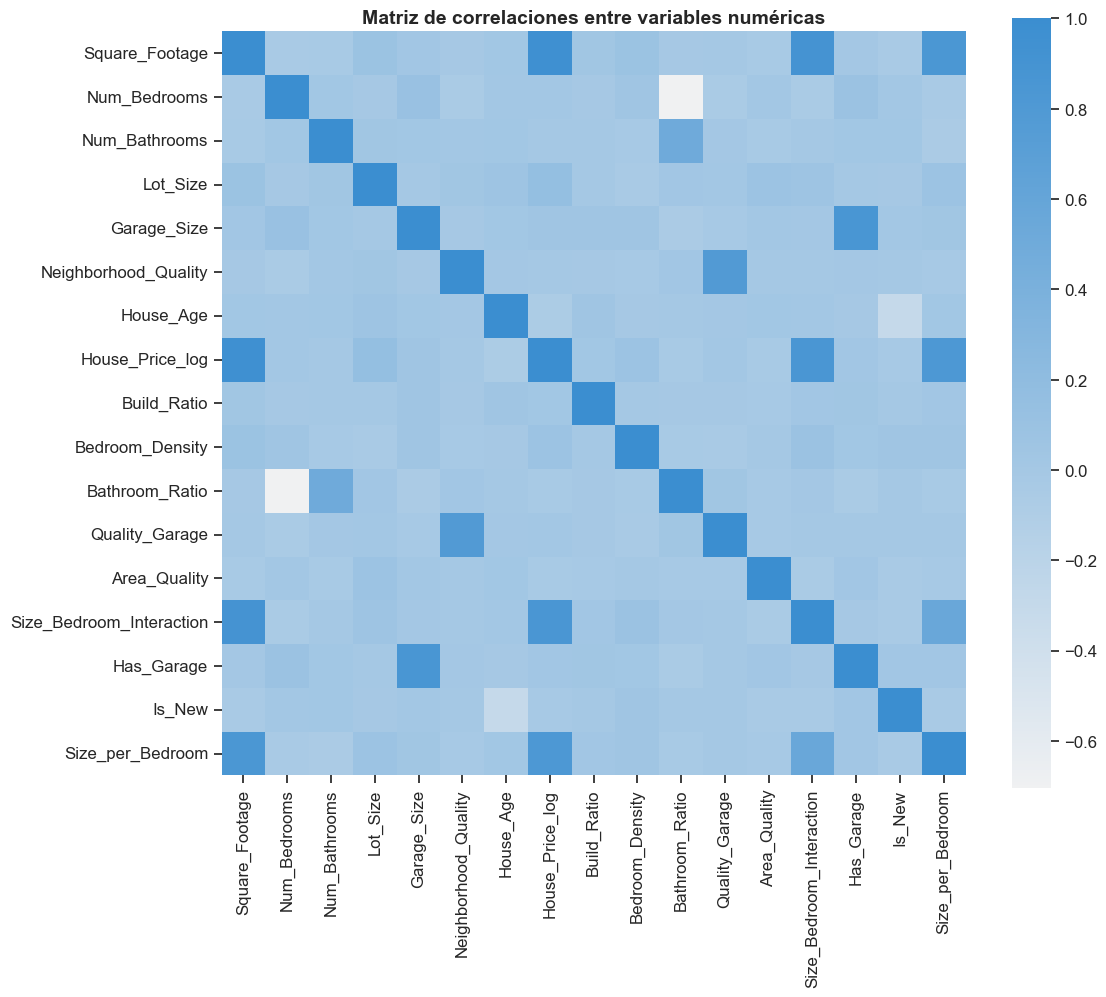

Correlación de cada variable con House_Price_log:
House_Price_log             1.000000
Square_Footage              0.960967
Size_Bedroom_Interaction    0.859944
Size_per_Bedroom            0.823295
Lot_Size                    0.156019
Bedroom_Density             0.085169
Garage_Size                 0.048134
Has_Garage                  0.031350
Build_Ratio                 0.025557
Num_Bedrooms                0.018016
Quality_Garage              0.017104
Neighborhood_Quality       -0.000283
Num_Bathrooms              -0.000839
Is_New                     -0.015423
Area_Quality               -0.028563
Bathroom_Ratio             -0.032081
House_Age                  -0.064254
Name: House_Price_log, dtype: float64


In [332]:
# Seleccionar solo variables numéricas (excluye texto o categóricas)
data_num = data_fin.select_dtypes(include=['float64', 'int64']).copy()

# Calcular matriz de correlación
corr = data_num.corr()

# Graficar
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap=sns.light_palette("#3b8ed0", as_cmap=True), annot=False, square=True)
plt.title("Matriz de correlaciones entre variables numéricas", fontsize=14, weight="bold")
plt.show()

# Mostrar correlación con el precio (House_Price_log)
corr_target = corr['House_Price_log'].sort_values(ascending=False)
print("Correlación de cada variable con House_Price_log:")
print(corr_target)

In [333]:
# Seleccionamos las variables más correlacionadas con el precio 
vars_vif = [
    'Square_Footage',
    'Size_Bedroom_Interaction',
    'Size_per_Bedroom',
    'Lot_Size',
    'House_Age'
]

# Creamos un DataFrame con esas columnas
X_vif = data_fin[vars_vif].copy()

# Agregamos una constante 
X_vif['const'] = 1

# Calculamos el VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Eliminamos la constante de la tabla
vif_data = vif_data[vif_data['Variable'] != 'const']

# Mostramos resultados ordenados
vif_data.sort_values(by='VIF', ascending=False)

,Variable,VIF
0,Square_Footage,69.316040
1,Size_Bedroom_Interaction,28.573695
2,Size_per_Bedroom,18.464222
3,Lot_Size,1.014826
4,House_Age,1.004306


In [334]:
# Eliminamos las dos variables con VIF elevado
data_fin = data_fin.drop(columns=['Size_Bedroom_Interaction', 'Size_per_Bedroom'])

# Verificamos que fueron eliminadas
data_fin.columns

Index(['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size',
       'Garage_Size', 'Neighborhood_Quality', 'House_Age', 'House_Price_log',
       'Build_Ratio', 'Bedroom_Density', 'Bathroom_Ratio', 'Quality_Garage',
       'Area_Quality', 'Has_Garage', 'Is_New'],
      dtype='object')

**Comentario:** Se eliminaron las variables *Size_Bedroom_Interaction* y *Size_per_Bedroom* debido a su alta multicolinealidad con *Square_Footage*, manteniendo las demás variables derivadas que aportan información independiente para la predicción del precio.

## 6) Modelo lineal

In [335]:
# Variables predictoras 
features_finales = [
    'Square_Footage', 'Lot_Size', 'Num_Bathrooms',
    'Neighborhood_Quality', 'Garage_Size', 
    'Build_Ratio', 'Quality_Garage', 
    'Area_Quality', 'Has_Garage', 
    'Is_New', 'House_Age'
]

X = data_fin[features_finales]
y = data_fin['House_Price_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train, y_train)
y_pred = modelo_lineal.predict(X_test)

In [336]:
# Evaluamos el modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Evaluación del modelo lineal:")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

Evaluación del modelo lineal:
MAE : 0.0942
MSE : 0.0172
RMSE: 0.1310
R²  : 0.9350


In [337]:
# Hacemos validación cruzada con los valores del MAE en dólares
def mae_en_dolares(y_true_log, y_pred_log):
    y_true_real = np.exp(y_true_log)
    y_pred_real = np.exp(y_pred_log)
    return mean_absolute_error(y_true_real, y_pred_real)

mae_usd_scorer = make_scorer(mae_en_dolares, greater_is_better=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(modelo_lineal, X, y, cv=kfold, scoring=mae_usd_scorer)
cv_scores = -cv_scores

print("Validación cruzada (MAE USD por fold):", cv_scores.round(2))
print("MAE promedio (USD):", np.mean(cv_scores).round(2))
print("Desviación estándar:", np.std(cv_scores).round(2))

Validación cruzada (MAE USD por fold): [50423.51 54993.36 51487.27 59218.84 56724.48]
MAE promedio (USD): 54569.49
Desviación estándar: 3259.73


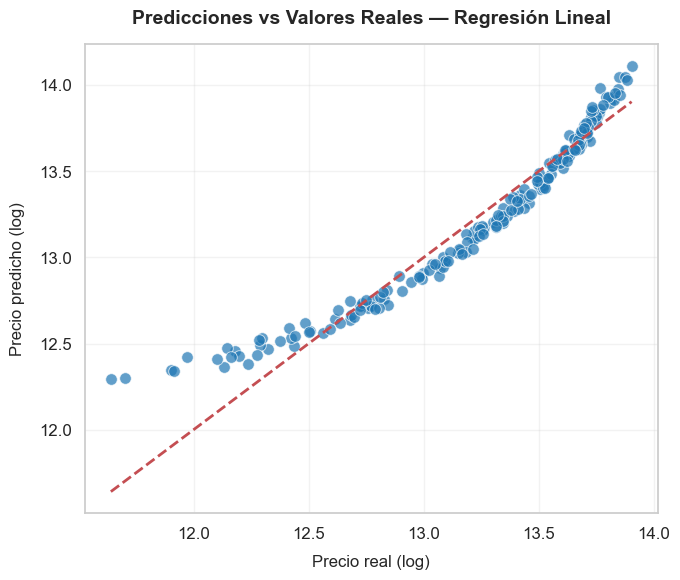

In [338]:
# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=y_test, y=y_pred,
    color="#1f77b4",
    edgecolor="white",
    alpha=0.7, s=70
)

# Línea de referencia
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2
)

# Título y etiquetas
plt.title("Predicciones vs Valores Reales — Regresión Lineal",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Precio real (log)", fontsize=12, labelpad=10)
plt.ylabel("Precio predicho (log)", fontsize=12, labelpad=10)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

## 7) Modelos no lineales

### Random Forest

In [339]:
# Definimos modelo
modelo_rf = RandomForestRegressor(
    n_estimators=200,    
    max_depth=None,     
    random_state=42,
    n_jobs=-1            
)

# Entrenamiento
modelo_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = modelo_rf.predict(X_test)

In [340]:
# Evaluamos el modelo
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Evaluación del modelo Random Forest:")
print(f"MAE : {mae_rf:.4f}")
print(f"MSE : {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²  : {r2_rf:.4f}")

Evaluación del modelo Random Forest:
MAE : 0.0352
MSE : 0.0026
RMSE: 0.0514
R²  : 0.9900


In [341]:
# Hacemos validación cruzada con los valores del MAE en dólares
def mae_en_dolares(y_true_log, y_pred_log):
    y_true_real = np.exp(y_true_log)
    y_pred_real = np.exp(y_pred_log)
    return mean_absolute_error(y_true_real, y_pred_real)

mae_usd_scorer = make_scorer(mae_en_dolares, greater_is_better=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores_rf = cross_val_score(modelo_rf, X, y, cv=kfold, scoring=mae_usd_scorer)
scores_rf = -scores_rf

print("MAE USD por fold:", scores_rf.round(2))
print("MAE promedio (USD):", np.mean(scores_rf).round(2))
print("Desviación estándar:", np.std(scores_rf).round(2))

MAE USD por fold: [17685.46 19178.61 17834.89 19735.79 17977.51]
MAE promedio (USD): 18482.45
Desviación estándar: 820.36


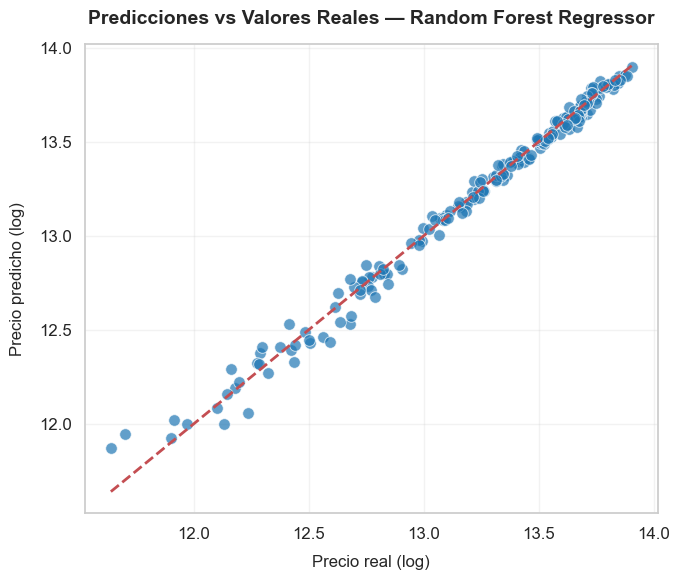

In [342]:
# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=y_test, y=y_pred_rf,
    color="#1f77b4",  
    edgecolor="white",
    alpha=0.7, s=70
)

# Línea de referencia
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2
)


plt.title("Predicciones vs Valores Reales — Random Forest Regressor",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Precio real (log)", fontsize=12, labelpad=10)
plt.ylabel("Precio predicho (log)", fontsize=12, labelpad=10)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

### XGBoost

In [343]:
# Definir el modelo
modelo_xgb = XGBRegressor(
    n_estimators=500,      
    learning_rate=0.05,     
    max_depth=4,           
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42
)

# Entrenamiento
modelo_xgb.fit(X_train, y_train)

# Predicciones
y_pred_xgb = modelo_xgb.predict(X_test)

In [344]:
# Evaluamos el modelo
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Evaluación del modelo XGBoost:")
print(f"MAE : {mae_xgb:.4f}")
print(f"MSE : {mse_xgb:.4f}")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²  : {r2_xgb:.4f}")

Evaluación del modelo XGBoost:
MAE : 0.0346
MSE : 0.0025
RMSE: 0.0504
R²  : 0.9904


In [345]:
# Hacemos validación cruzada con los valores del MAE en dólares
def mae_en_dolares(y_true_log, y_pred_log):
    y_true_real = np.exp(y_true_log)
    y_pred_real = np.exp(y_pred_log)
    return mean_absolute_error(y_true_real, y_pred_real)

mae_usd_scorer = make_scorer(mae_en_dolares, greater_is_better=False)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores_xgb = cross_val_score(modelo_xgb, X, y, cv=kfold, scoring=mae_usd_scorer)

scores_xgb = -scores_xgb

print("MAE USD por fold:", scores_xgb.round(0))
print("MAE promedio (USD):", np.mean(scores_xgb).round(2))
print("Desviación estándar:", np.std(scores_xgb).round(2))

MAE USD por fold: [17810. 21483. 18794. 19736. 18892.]
MAE promedio (USD): 19343.02
Desviación estándar: 1232.13


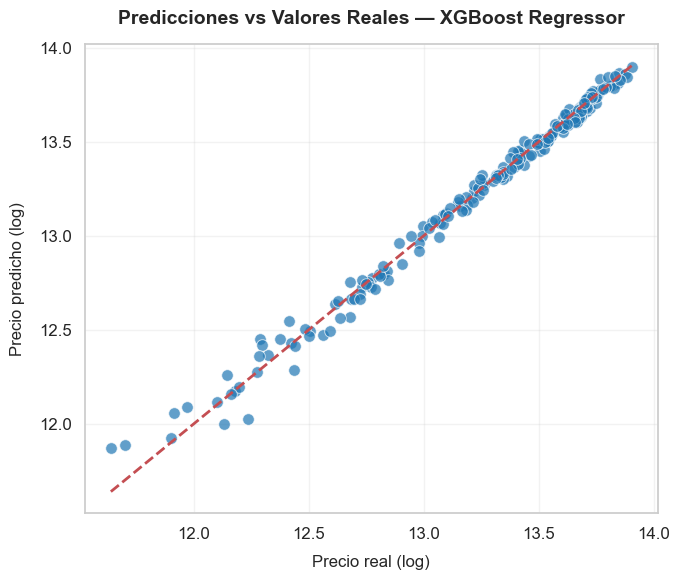

In [346]:
# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=y_test, y=y_pred_xgb,
    color="#1f77b4",
    edgecolor="white",
    alpha=0.7, s=70
)

# Línea de referencia
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2
)

# Título y etiquetas
plt.title("Predicciones vs Valores Reales — XGBoost Regressor",
          fontsize=14, weight='bold', pad=15)
plt.xlabel("Precio real (log)", fontsize=12, labelpad=10)
plt.ylabel("Precio predicho (log)", fontsize=12, labelpad=10)
plt.grid(alpha=0.25)
plt.tight_layout()

# Mostrar gráfico
plt.show()

### K-Nearest Neighbors Regressor (KNN)

In [347]:
# Definimos el modelo (k = 5 vecinos)
modelo_knn = KNeighborsRegressor(n_neighbors=5)

# Entrenamiento
modelo_knn.fit(X_train, y_train)

# Predicciones
y_pred_knn = modelo_knn.predict(X_test)

In [348]:
# Evaluamos el modelo
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("Evaluación del modelo KNN:")
print(f"MAE : {mae_knn:.4f}")
print(f"MSE : {mse_knn:.4f}")
print(f"RMSE: {rmse_knn:.4f}")
print(f"R²  : {r2_knn:.4f}")

Evaluación del modelo KNN:
MAE : 0.2381
MSE : 0.1155
RMSE: 0.3398
R²  : 0.5627


In [349]:
# Hacemos validación cruzada con los valores del MAE en dólares
def mae_en_dolares(y_true_log, y_pred_log):
    y_true_real = np.exp(y_true_log)
    y_pred_real = np.exp(y_pred_log)
    return mean_absolute_error(y_true_real, y_pred_real)

mae_usd_scorer = make_scorer(mae_en_dolares, greater_is_better=False)


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scores_knn = cross_val_score(modelo_knn, X, y, cv=kfold, scoring=mae_usd_scorer)

scores_knn = -scores_knn

print("MAE USD por fold:", scores_knn.round(2))
print("MAE promedio (USD):", np.mean(scores_knn).round(2))
print("Desviación estándar:", np.std(scores_knn).round(2))

MAE USD por fold: [123878.58 117969.1  115282.59 119532.19 115620.2 ]
MAE promedio (USD): 118456.53
Desviación estándar: 3127.68


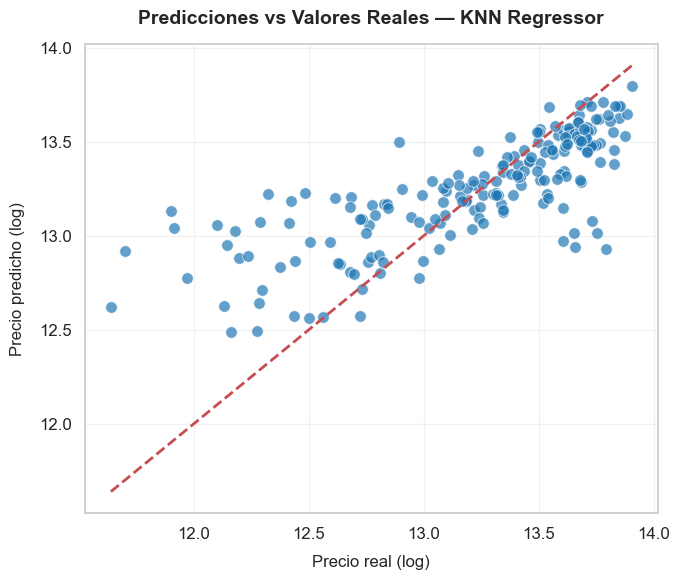

In [350]:
# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=y_test, y=y_pred_knn,
    color="#1f77b4", edgecolor="white",
    alpha=0.7, s=70
)

# Línea de referencia 
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2
)

# Etiquetas y título
plt.title("Predicciones vs Valores Reales — KNN Regressor", fontsize=14, weight='bold', pad=15)
plt.xlabel("Precio real (log)", fontsize=12, labelpad=10)
plt.ylabel("Precio predicho (log)", fontsize=12, labelpad=10)
plt.grid(alpha=0.25)
plt.tight_layout()

# Mostrar gráfico
plt.show()


## 8) Implementación y resultados

### Calculamos métricas

In [351]:
# Calculamos metricas en escala log y en dólares
def r2_ajustado(r2, n, p):
    denom = max(n - p - 1, 1)
    return 1 - (1 - r2) * (n - 1) / denom

def eval_log(nombre, modelo, X_train, X_test, y_train, y_test):
    y_train_pred = modelo.predict(X_train)
    y_test_pred  = modelo.predict(X_test)

    mae_tr  = mean_absolute_error(y_train, y_train_pred)
    rmse_tr = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_tr   = r2_score(y_train, y_train_pred)

    mae_te  = mean_absolute_error(y_test, y_test_pred)
    rmse_te = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_te   = r2_score(y_test, y_test_pred)

    p = X_train.shape[1]
    r2adj_tr = r2_ajustado(r2_tr, len(y_train), p)
    r2adj_te = r2_ajustado(r2_te, len(y_test), p)

    return [
        nombre,
        mae_tr, rmse_tr, r2_tr, r2adj_tr,
        mae_te, rmse_te, r2_te, r2adj_te
    ]

tabla_log = pd.DataFrame(
    [
        eval_log("Lineal", modelo_lineal, X_train, X_test, y_train, y_test),
        eval_log("Random Forest", modelo_rf, X_train, X_test, y_train, y_test),
        eval_log("XGBoost", modelo_xgb, X_train, X_test, y_train, y_test),
        eval_log("KNN", modelo_knn, X_train, X_test, y_train, y_test),
    ],
    columns=[
        "Modelo",
        "MAE_Train", "RMSE_Train", "R²_Train", "R²_Ajustado_Train",
        "MAE_Test", "RMSE_Test", "R²_Test", "R²_Ajustado_Test"
    ]
).round(4)


def eval_mae_usd(nombre, modelo, X_train, X_test, y_train, y_test):
    y_train_pred_log = modelo.predict(X_train)
    y_test_pred_log  = modelo.predict(X_test)

    y_train_real      = np.exp(y_train)
    y_train_pred_real = np.exp(y_train_pred_log)
    y_test_real       = np.exp(y_test)
    y_test_pred_real  = np.exp(y_test_pred_log)

    mae_tr_usd = mean_absolute_error(y_train_real, y_train_pred_real)
    mae_te_usd = mean_absolute_error(y_test_real, y_test_pred_real)

    return [nombre, mae_tr_usd, mae_te_usd]

tabla_usd = pd.DataFrame(
    [
        eval_mae_usd("Lineal", modelo_lineal, X_train, X_test, y_train, y_test),
        eval_mae_usd("Random Forest", modelo_rf, X_train, X_test, y_train, y_test),
        eval_mae_usd("XGBoost", modelo_xgb, X_train, X_test, y_train, y_test),
        eval_mae_usd("KNN", modelo_knn, X_train, X_test, y_train, y_test),
    ],
    columns=["Modelo", "MAE_Train_USD", "MAE_Test_USD"]
).round(0)

estilo = [
    {'selector': 'caption', 'props': [('font-size','15px'),
                                      ('font-weight','bold'),
                                      ('text-align','center')]},
    {'selector': 'th',      'props': [('background-color','#005b96'),
                                      ('color','white'),
                                      ('text-align','center')]}
]

def resaltar_filas_medias(row):
    if row.name in [1, 2]: 
        return ['background-color: #d4edda'] * len(row)
    return [''] * len(row)

display(
    tabla_log.style
        .set_caption("Métricas en escala logarítmica — Train y Test")
        .set_table_styles(estilo)
        .set_properties(**{'text-align': 'center', 'font-size': '12px'})
        .apply(resaltar_filas_medias, axis=1)
)


display(
    tabla_usd.style
        .set_caption("MAE en dólares — Train y Test")
        .set_table_styles(estilo)
        .set_properties(**{'text-align': 'center', 'font-size': '12px'})
        .apply(resaltar_filas_medias, axis=1)
)


,Modelo,MAE_Train,RMSE_Train,R²_Train,R²_Ajustado_Train,MAE_Test,RMSE_Test,R²_Test,R²_Ajustado_Test
0,Lineal,0.093400,0.120200,0.938700,0.937900,0.094200,0.131000,0.935000,0.931200
1,Random Forest,0.014500,0.021200,0.998100,0.998100,0.035200,0.051400,0.990000,0.989400
2,XGBoost,0.010700,0.013700,0.999200,0.999200,0.034600,0.050400,0.990400,0.989800
3,KNN,0.179900,0.253500,0.727500,0.723700,0.238100,0.339800,0.562700,0.537200


,Modelo,MAE_Train_USD,MAE_Test_USD
0,Lineal,53407.000000,50424.000000
1,Random Forest,7115.000000,17678.000000
2,XGBoost,6154.000000,17496.000000
3,KNN,94333.000000,123879.000000


**Comentario:** Luego de identificar a Random Forest y XGBoost como los modelos con mejor desempeño inicial, se realizó un proceso de ajuste de hiperparámetros para evaluar si era posible mejorar su precisión y capacidad de generalización. Para ello, se entrenaron múltiples iteraciones de cada modelo modificando parámetros clave midiendo en cada caso el MAE en escala logarítmica y el MAE en dólares, tanto en train como en test. Este procedimiento permitió analizar cómo afectan los hiperparámetros al comportamiento del modelo, buscando reducir el error y, al mismo tiempo, disminuir la brecha entre el conjunto de entrenamiento y el de prueba.

### Iteraciones en Random Forest

In [356]:
iteraciones_rf = [
    {"n_estimators": 200, "max_depth": None,
     "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},

    {"n_estimators": 400, "max_depth": None,
     "min_samples_split": 2, "min_samples_leaf": 1, "max_features": "sqrt"},

    {"n_estimators": 300, "max_depth": None,
     "min_samples_split": 4, "min_samples_leaf": 2, "max_features": "sqrt"},

    {"n_estimators": 600, "max_depth": None,
     "min_samples_split": 4, "min_samples_leaf": 2, "max_features": "sqrt"},

    {"n_estimators": 300, "max_depth": None,
     "min_samples_split": 2, "min_samples_leaf": 1, "max_features": None},
]

def evaluar_rf_iteracion(modelo_rf, params):

    modelo_rf.set_params(**params)
    modelo_rf.fit(X_train, y_train)

    y_tr_pred = modelo_rf.predict(X_train)
    y_te_pred = modelo_rf.predict(X_test)

    mae_tr = mean_absolute_error(y_train, y_tr_pred)
    mae_te = mean_absolute_error(y_test, y_te_pred)

    mae_tr_usd = mean_absolute_error(np.exp(y_train), np.exp(y_tr_pred))
    mae_te_usd = mean_absolute_error(np.exp(y_test), np.exp(y_te_pred))

    return mae_tr, mae_te, mae_tr_usd, mae_te_usd


tabla_iter_rf = []

for i, params in enumerate(iteraciones_rf, start=1):

    mae_tr, mae_te, mae_tr_usd, mae_te_usd = evaluar_rf_iteracion(modelo_rf, params)

    tabla_iter_rf.append([
        i,
        params["n_estimators"],
        params["max_depth"],
        params["min_samples_split"],
        params["min_samples_leaf"],
        params["max_features"],
        round(mae_tr, 4),
        round(mae_te, 4),
        round(mae_tr_usd, 0),
        round(mae_te_usd, 0)
    ])

tabla_iter_rf = pd.DataFrame(
    tabla_iter_rf,
    columns=[
        "Iteración", "n_estimators", "max_depth", "min_samples_split",
        "min_samples_leaf", "max_features",
        "MAE_Train_log", "MAE_Test_log",
        "MAE_Train_USD", "MAE_Test_USD"
    ]
)

estilo_iter = [
    {'selector': 'caption',
     'props': [('font-size','15px'),
               ('font-weight','bold'),
               ('text-align','center')]},

    {'selector': 'th',
     'props': [('background-color','#005b96'),
               ('color','white'),
               ('text-align','center')]}
]

display(
    tabla_iter_rf.style
        .set_caption("Random Forest — Iteraciones de Hiperparámetros")
        .set_table_styles(estilo_iter)
        .set_properties(**{'text-align': 'center', 'font-size': '12px'})
)

,Iteración,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,MAE_Train_log,MAE_Test_log,MAE_Train_USD,MAE_Test_USD
0,1,200,None,2,1,sqrt,0.020600,0.051600,10679.000000,25218.000000
1,2,400,None,2,1,sqrt,0.020300,0.051900,10450.000000,25380.000000
2,3,300,None,4,2,sqrt,0.029100,0.053900,14943.000000,26272.000000
3,4,600,None,4,2,sqrt,0.029300,0.054000,15020.000000,26530.000000
4,5,300,None,2,1,None,0.014400,0.035200,7100.000000,17621.000000


**Comentario:** Aunque la última iteración del Random Forest obtuvo un MAE_Test_USD levemente inferior al del modelo original, la mejora fue mínima aprox 15 USD, una diferencia insignificante dentro del rango de precios del dataset. Además, las demás métricas se mantuvieron prácticamente iguales. Esto indica que el modelo original ya estaba adecuadamente ajustado y que las variaciones introducidas en los hiperparámetros no aportaron una mejora significativa ni en precisión ni en capacidad de generalización.


### Iteraciones en XGBoost

In [354]:
iteraciones_xgb = [
    {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 4, "subsample": 0.9, "colsample_bytree": 0.9},
    {"n_estimators": 300, "learning_rate": 0.05, "max_depth": 5, "subsample": 0.9, "colsample_bytree": 0.9},
    {"n_estimators": 400, "learning_rate": 0.05, "max_depth": 4, "subsample": 0.8, "colsample_bytree": 0.8},
    {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "subsample": 0.9, "colsample_bytree": 0.9},
    {"n_estimators": 600, "learning_rate": 0.03, "max_depth": 5, "subsample": 0.8, "colsample_bytree": 0.8},
]


def evaluar_xgb_iteracion(modelo_xgb, params):
    modelo_xgb.set_params(**params)
    modelo_xgb.fit(X_train, y_train)
    y_tr_pred = modelo_xgb.predict(X_train)
    y_te_pred = modelo_xgb.predict(X_test)
    mae_tr = mean_absolute_error(y_train, y_tr_pred)
    mae_te = mean_absolute_error(y_test, y_te_pred)
    mae_tr_usd = mean_absolute_error(np.exp(y_train), np.exp(y_tr_pred))
    mae_te_usd = mean_absolute_error(np.exp(y_test), np.exp(y_te_pred))
    return mae_tr, mae_te, mae_tr_usd, mae_te_usd

tabla_iter_xgb = []

for i, params in enumerate(iteraciones_xgb, start=1):
    mae_tr, mae_te, mae_tr_usd, mae_te_usd = evaluar_xgb_iteracion(modelo_xgb, params)
    tabla_iter_xgb.append([
        i, params["n_estimators"], params["learning_rate"], params["max_depth"],
        params["subsample"], params["colsample_bytree"],
        round(mae_tr, 4), round(mae_te, 4),
        round(mae_tr_usd, 0), round(mae_te_usd, 0)
    ])

tabla_iter_xgb = pd.DataFrame(
    tabla_iter_xgb,
    columns=[
        "Iteración", "n_estimators", "learning_rate",
        "max_depth", "subsample", "colsample_bytree",
        "MAE_Train_log", "MAE_Test_log",
        "MAE_Train_USD", "MAE_Test_USD"
    ]
)

estilo_iter = [
    {'selector': 'caption','props': [('font-size','15px'),('font-weight','bold'),('text-align','center')]},
    {'selector': 'th','props': [('background-color','#005b96'),('color','white'),('text-align','center')]}
]

display(
    tabla_iter_xgb.style
        .set_caption("XGBoost — Iteraciones de Hiperparámetros")
        .set_table_styles(estilo_iter)
        .set_properties(**{'text-align':'center','font-size':'12px'})

)



,Iteración,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,MAE_Train_log,MAE_Test_log,MAE_Train_USD,MAE_Test_USD
0,1,200,0.100000,4,0.900000,0.900000,0.011800,0.034900,6713.000000,17222.000000
1,2,300,0.050000,5,0.900000,0.900000,0.008500,0.034500,4915.000000,16946.000000
2,3,400,0.050000,4,0.800000,0.800000,0.012700,0.034600,7288.000000,17482.000000
3,4,500,0.050000,6,0.900000,0.900000,0.001900,0.033800,1156.000000,16701.000000
4,5,600,0.030000,5,0.800000,0.800000,0.007600,0.036000,4434.000000,17800.000000


**Comentario:** Las iteraciones realizadas sobre XGBoost no lograron mejorar de manera significativa el desempeño del modelo original. Aunque algunas configuraciones produjeron leves variaciones en el MAE ninguna reducción fue suficientemente relevante como para superar al modelo base. Las diferencias en MAE_Test_USD estuvieron dentro de márgenes muy pequeños, sin aportar mejoras reales en la capacidad predictiva. Además, ciertas configuraciones redujeron demasiado el error en entrenamiento, aumentando el riesgo de sobreajuste sin beneficios en los datos de prueba. En conjunto, los resultados indican que el modelo XGBoost original ya estaba adecuadamente ajustado, y que los cambios explorados en los hiperparámetros no brindaron ventajas adicionales en precisión ni en generalización.

### Conclusión

Al comparar las métricas de train y test, se observa que **Random Forest** y **XGBoost** presentan valores de error muy similares en ambos conjuntos, lo que refleja una excelente capacidad de generalización. Ambos modelos logran captar los patrones del conjunto de entrenamiento sin sobreajustarse, manteniendo un rendimiento alto también en los datos de prueba.

El **modelo lineal** muestra un desempeño menor pero estable, sin señales de overfitting, por lo que constituye una opción simple pero menos precisa. En contraste, **KNN** presenta el rendimiento más bajo y una brecha importante entre train y test, lo cual indica dificultades para capturar la complejidad del problema.

En conjunto, **Random Forest** y **XGBoost** son los modelos más sólidos, destacándose **XGBoost** por obtener el MAE en dólares más bajo, razón por la cual se selecciona como el modelo final para la predicción del precio de viviendas.
